<a href="https://colab.research.google.com/github/arghyadeep99/CoronaXiv-Pre-Processing/blob/master/CoronaXiv%20Pre-Processing%20and%20ML%20Model%20Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Required Libraries

In [ ]:
!pip3 install numpy pandas tqdm semanticscholar langdetect crossref altmetric sklearn torch sentence_transformers nltk tsnecuda

## Necessary Imports

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import os
import csv
import glob
import json
import re
import pickle
from multiprocessing import Pool
from IPython.display import display, Latex, HTML, FileLink
import joblib
import requests
import urllib

from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import semanticscholar as sch
from langdetect import detect
from crossref.restful import Works, Journals
from altmetric import Altmetric

from sklearn.metrics.pairwise import cosine_similarity
import torch
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelWithLMHead

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

%matplotlib inline

/home/arghyadeep99/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Import from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

## Define Paths to directories

In [ ]:
PROJECT_PATH = "" #ADD YOUR PROJECT PATH
DATASET_PATH = PROJECT_PATH + "" #ADD PATH TO DATASET
EXPORT_PATH = PROJECT_PATH + "" #ADD PATH TO WHERE THE EMBEDDINGS, CSVS AND NPY FILE WILL BE EXPORTED

if not os.path.exists(EXPORT_PATH):
    os.makedirs(EXPORT_PATH)
!ls $PROJECT_PATH

FileNotFoundError: [Errno 2] No such file or directory: ''

## Pre-Processing 

In [ ]:
#Parse all JSONs and store in a variable
all_json = glob.glob(os.path.join(DATASET_PATH, "document_parses/**/*.json"), recursive=True)

In [ ]:
#Store metadata information in a variable
metadata_df = pd.read_csv(os.path.join(DATASET_PATH, 'metadata.csv'), 
                      low_memory=False, 
                      dtype={
                            'pubmed_id': str,
                            'Microsoft Academic Paper ID': str, 
                            'doi': str
                        }
                     )

In [ ]:
metadata_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
class PaperReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except:
                self.abstract.append("No abstract available")
            for entry in content["body_text"]:
                self.body_text.append(entry['text'])
            self.abstract = '. '.join(self.abstract)
            self.body_text = '. '.join(self.body_text)
    def __repr__(self):
        return f"{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}..."

In [ ]:
dict_ = {'paper_id': [], 
         'abstract': [], 
         'body_text': [], 
         'authors': [], 
         'title': [], 
         'journal': [], 
         'publish_time': [], 
         'abstract_summary': [],
         'doi': [],
         'url': [],
         'source_x': []
        }

for idx, entry in tqdm_notebook(enumerate(all_json), total=len(all_json)):
    content = PaperReader(entry)
    
    # get metadata information
    meta_data = metadata_df.loc[metadata_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    try:
        authors = meta_data['authors'].values[0].split(';')
        dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if Null value
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information
    dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add the publishing data
    dict_['publish_time'].append(meta_data['publish_time'].values[0])
    
    # add doi 
    dict_['doi'].append(meta_data['doi'].values[0])
    
    # add source
    dict_['source_x'].append(meta_data['source_x'].values[0])
    
    # add url
    dict_['url'].append(meta_data['url'].values[0])    

In [ ]:
columns = ['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'publish_time', 'doi', 
           'source_x', 'url']

df_covid = pd.DataFrame(dict_, columns=columns)

In [ ]:
df_covid.to_csv(os.path.join(EXPORT_PATH, 'original.csv'), index=False)

In [ ]:
df_covid.drop_duplicates(['title'], inplace=True)
df_covid.dropna(subset=['body_text'], inplace=True)
df_covid = df_covid[~df_covid.title.isnull()]
df_covid.reset_index(inplace=True, drop=True)

In [ ]:
covid_terms =['covid', 'corona virus', 'coronavirus disease 19', 'sars cov 2', '2019 ncov', '2019ncov', '2019 n cov', '2019n cov',
              'ncov 2019', 'n cov 2019', 'coronavirus 2019', 'wuhan pneumonia', 'wuhan virus', 'wuhan coronavirus',
              'coronavirus 2', 'covid-19', 'SARS-CoV-2', '2019-nCov']
covid_terms = [elem.lower() for elem in covid_terms]
covid_terms = re.compile('|'.join(covid_terms))

def checkYear(date):
    return int(date[0:4])

def checkCovid(row, covid_terms):
    return bool(covid_terms.search(row['body_text'].lower())) and checkYear(row['publish_time']) > 2019
df_covid['is_covid'] = df_covid.progress_apply(checkCovid, axis=1, covid_terms=covid_terms)

In [ ]:
#Keeping papers only after 2010
df_covid = df_covid[df_covid.publish_time.map(lambda d: checkYear(d) >= 2010)]
df_covid = df_covid.reset_index(drop=True)

In [ ]:
def preprocessing(text):
    # remove mail
    text = re.sub(r'[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}', ' ', text)
    # remove doi
    text = re.sub(r'https\:\/\/doi\.org[^\s]+', 'DOI', text)
    # remove https
    text = re.sub(r'(\()?\s?http(s)?\:\/\/[^\)]+(\))?', ' ', text)
    # remove single characters repeated at least 3 times for spacing error (e.g. s u m m a r y)
    text = re.sub(r'(\w\s+){3,}', ' ', text)
    # replace tags (e.g. [3] [4] [5]) with whitespace
    text = re.sub(r'(\[\d+\]\,?\s?){3,}(\.|\,)?', ' ', text)
    # replace tags (e.g. [3, 4, 5]) with whitespace
    text = re.sub(r'\[[\d\,\s]+\]', ' ', text)
     # replace tags (e.g. (NUM1) repeated at least 3 times with whitespace
    text = re.sub(r'(\(\d+\)\s){3,}', ' ', text)
    # replace '1.3' with '1,3' (we need it for split later)
    text = re.sub(r'(\d+)\.(\d+)', ' ', text)
    # remove all full stops as abbreviations (e.g. i.e. cit. and so on)
    text = re.sub(r'\.(\s)?([^A-Z\s])', ' \g<1>\g<2>', text)
    # correctly spacing the tokens
    text = re.sub(r' {2,}', ' ', text)
    text = re.sub(r'\.{2,}', '.', text)
    # return lowercase text
    return text.lower()

df_covid['preproc_body_text'] = df_covid['body_text'].progress_apply(preprocessing)

### Filtering out only English Research Papers

In [ ]:
def detect_language(row):
    try:
        return detect(row['preproc_body_text'])
    except:
        try:
            return detect(row['title'])
        except: 
            return 'NC'

df_covid['language'] = df_covid.progress_apply(detect_language, axis=1)
df_covid = df_covid[df_covid['language'] == 'en']
df_covid = df_covid.reset_index(drop=True)

 cord-19-dataset		       covidbert-model
'CoronaXiv Data Preprocessing.ipynb'   exported-data


In [ ]:
df_covid.to_csv(os.path.join(EXPORT_PATH, 'metadata.csv'), index=False)

In [ ]:
doi_list = df_covid[~df_covid['doi'].isnull()]['doi'].unique().tolist()

### Scrapping additional metadata about citations using the Altmetrics API

In [ ]:
scrape_altmetrics = False

if scrape_altmetrics:
    def get_altmetric_data(doi):
        res = a.doi(doi)
        return res
    
    altmetrics_data = []
    a = Altmetric()

    for doi in tqdm_notebook(doi_list):
        res = a.doi(doi)
        altmetrics_data.append(res)

    altmetrics_data = [d for d in altmetrics_data if d is not None]
    
    altmetrics_columns = [
        'doi',
        'score',
        'readers_count',
        'cited_by_posts_count',
        'cited_by_tweeters_count',
        'cited_by_fbwalls_count',
        'cited_by_wikipedia_count',
        'subjects',
    ]

    df_altmetrics = pd.DataFrame(altmetrics_data, columns=altmetrics_columns)
    joblib.dump(df_altmetrics, os.path.join(EXPORT_PATH, 'altmetrics.joblib'))

else:
    df_altmetrics = joblib.load(os.path.join(EXPORT_PATH, 'altmetrics.joblib'))

NameError: name 'export_path' is not defined

In [ ]:
df_covid = df_covid.merge(df_altmetrics, how='left', on='doi')

In [ ]:
df_covid.to_csv(os.path.join(EXPORT_PATH, 'metadata.csv'), index=False)

### Scrapping H-Index using Scimago API

In [ ]:
scrape_scimago = True
df_covid = metadata
if scrape_scimago:

    def parse_page(url):
        return BeautifulSoup(requests.get(url).content, 'html.parser')
    
    journals = df_covid.journal.dropna().unique().tolist()    

    def get_h_index(url):
        soup = parse_page(url)
        h_index_div = soup.find('div', {'class': 'hindexnumber'})
        if h_index_div:
            h_index = h_index_div.text
        return h_index

    def extract_info(query):
        original_title = query
        query = urllib.parse.quote_plus(query)
        url = f"https://www.scimagojr.com/journalsearch.php?q={query}"
        soup = parse_page(url)

        search_results = soup.find('div', {'class': 'search_results'}).find_all('a')
        if search_results == []:
            full_title = None
            h_index = None

        else:
            first_result = search_results[0]
            full_title = first_result.find('span').text
            url_journal = 'https://www.scimagojr.com/' + first_result['href']
            h_index = get_h_index(url_journal)

        info = {
            'original_title': original_title,
            'query': query,
            'full_title': full_title,
            'h_index': h_index
        }
        return info

    with Pool(processes=12) as pool, tqdm_notebook(total=len(journals)) as pbar:
        scimago_data = []
        for info in pool.imap_unordered(extract_info, journals):
            scimago_data.append(info)
            pbar.update()
            
    df_scimago = pd.DataFrame(scimago_data)
    joblib.dump(df_scimago, os.path.join(EXPORT_PATH, 'scimago.joblib'))

else:
    df_scimago = joblib.load(os.path.join(EXPORT_PATH, 'scimago.joblib'))
    

mapping_title_hindex = dict(zip(df_scimago['original_title'], df_scimago['h_index']))
df_covid['h_index'] = df_covid.journal.map(lambda j: mapping_title_hindex[j] if j in mapping_title_hindex else j)
df_covid['source_x'] = df_covid.source_x.map(lambda s: s.split(';')[0])

In [ ]:
df_covid['peer_reviewed'] = df_covid['journal'].map(lambda j: False if type(j) == float else True)

In [ ]:
df_covid.to_csv(os.path.join(EXPORT_PATH, 'metadata.csv'), index=False)

In [ ]:
def get_excerpt(row):
    if row['abstract'] == '':
        excerpt = row['title'] + ' . ' + row['preproc_body_text'][:500]
    else:
        len_abstract = len(row['abstract'])
        if len_abstract > 500:
            excerpt = row['title'] + ' . ' + preprocessing(row['abstract'][:500])
        else:
            excerpt = (row['title'] + ' . ' 
                       + preprocessing(row['abstract']) + ' . ' 
                       + row['preproc_body_text'][:500 - len_abstract])
        
    return excerpt

df_covid['excerpt'] = df_covid.progress_apply(get_excerpt, axis=1)
df_covid.to_csv(os.path.join(EXPORT_PATH, 'metadata.csv'), index=False)

## Generating Word Embeddings using the CovidBERT Model

In [ ]:
word_embedding_model = models.Transformer(os.path.join(PROJECT_PATH, "covidbert-model/"))

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/home/arghyadeep99/.local/lib/python3.8/site-packages/transformers/tokenization_utils.py:828: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  warnings.warn(


In [ ]:
excerpt_embeddings = model.encode(df_covid.excerpt.tolist(), show_progress_bar=True, batch_size=32)
excerpt_embeddings = np.array(excerpt_embeddings)
np.save(os.path.join(EXPORT_PATH, 'embeddings_excerpts.npy'), excerpt_embeddings)

Batches:   0%|          | 0/1648 [00:03<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device

In [ ]:
titles_embeddings = model.encode(df_covid.title.tolist(), show_progress_bar=True, batch_size=32)
titles_embeddings = np.array(titles_embeddings)
np.save(os.path.join(EXPORT_PATH, 'embeddings_titles.npy'), titles_embeddings)

In [ ]:
embeddings = np.load(os.path.join(EXPORT_PATH,'embeddings_excerpts.npy'))

In [ ]:
embeddings.shape

(52709, 768)

## Applying PCA to reduce dimensions from 768 to 250

In [ ]:
pca = PCA(n_components=250)
embeddings_reduced_pca = pca.fit_transform(embeddings)
print(f'cumulated variance : {pca.explained_variance_ratio_.sum()}')

cumulated variance : 0.8262177109718323


## Converting PCA to tSNE representation

In [ ]:
from tsnecuda import TSNE
import matplotlib.cm as cm
#from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=150, n_iter=1000)

'\nimport matplotlib.cm as cm\nfrom sklearn.manifold import TSNE\n\ntsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)\n'

In [ ]:
embeddings_reduced_tsne = tsne.fit_transform(embeddings_reduced_pca)

In [ ]:
%%script false --no-raise-error

df_tsne_coordinates = pd.DataFrame(embeddings_reduced_tsne, columns=['x1', 'x2'])
df_tsne_coordinates.to_csv(os.path.join(EXPORT_PATH, 'tsne_coordinates.csv'), index=False)
embeddings_reduced_tsne = pd.read_csv(os.path.join(EXPORT_PATH, 'tsne_coordinates.csv'))
np.save(os.path.join(EXPORT_PATH, 'tsne_coordinates.npy'), embeddings_reduced_tsne)

In [ ]:
embeddings_reduced_tsne = np.load(os.path.join(EXPORT_PATH,'tsne_coordinates.npy'))

In [ ]:
n_clusters = 8
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000)
predicted_labels = kmeans.fit_predict(embeddings_reduced_pca)

In [ ]:
silhouette = silhouette_score(embeddings_reduced_pca, predicted_labels, n_jobs=10)
sample_silhouette_values = silhouette_samples(embeddings_reduced_pca, predicted_labels, n_jobs=10)

Text(0.5, 1.0, 'tSNE representation of the data')

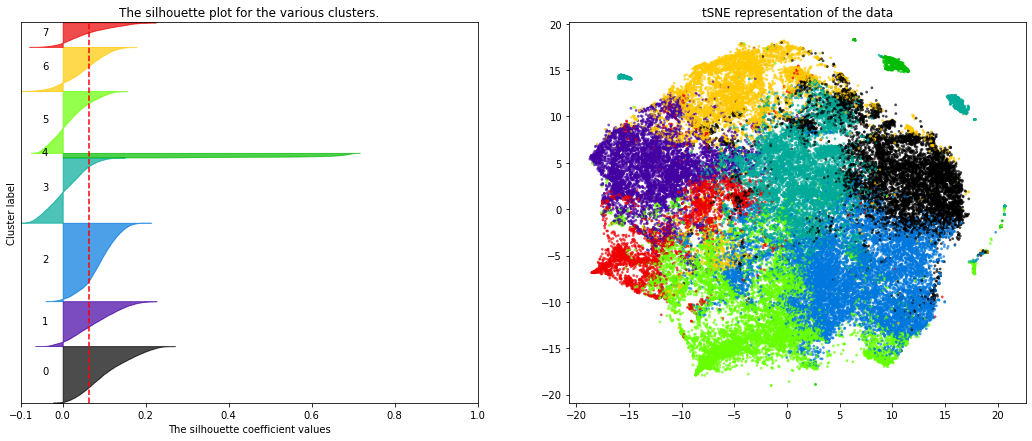

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(embeddings) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[predicted_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette, color="red", linestyle="--");

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.nipy_spectral(predicted_labels.astype(float) / n_clusters)
ax2.scatter(embeddings_reduced_tsne[:, 0], embeddings_reduced_tsne[:, 1], 
            marker='.', 
            s=30, 
            lw=0, 
            alpha=0.7,
            c=colors, 
            edgecolor='k')

ax2.set_title("tSNE representation of the data");

## Define Stopwords, Cleaner and Tokenizer

In [ ]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc.split()]
lemma_tokenizer = LemmaTokenizer()    

In [ ]:
response = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt")
STOPWORDS = response.text.split('\n')

response_fr = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt")
STOPWORDS_FR = response_fr.text.split('\n')
STOPWORDS += STOPWORDS_FR

STOPWORDS += ["et", "al", "fig", "figure", "can", "may", "also", "doi", "biorxiv", "preprint",
              "copyright", "peer-reviewed", "authorfunder", "table", "license", "à", "chapter",
             "abstract", "issue", "acute", "study", "approach", "inde", "index", "author", "unknown"]

STOPWORDS += ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 
              'myse', 'needn', 'oughtn', 'peer', 'reviewed', 'shan']

STOPWORDS += ["'d", "'m", "'re", "'s", "'t", '.', 'affect', 'change', 'doe', 'greeting', 'ha', 
              'i.e', 'key', 'le', "n't", 'regard', 'result', 'sha', 'ti', 'wa', 'wo', 'word', 
              '”', 'avon', 'diver', 'fuss', 'gen', 'quantum', 'serum', 'somme', 'sou']

STOPWORDS += ['respiratory', 'virus', 'infectious', 'disease', 'influenza', 'syndrome', 'infection', 
              'coronavirus', 'covid', 'mers', 'sars', 'cov', 'viral']

STOPWORDS += ['µ', 'µg', 'µl', 'µm', '¼', 'å', 'þ', 'β', 'β actin', 'β β', 'δ', 'ε', 'η', 'θ', 
              'κ', 'κb', 'λ', 'μ', 'μg', 'μl', 'μm', 'π', 'ρ', 'σ', 'φ', 'ω', 'α', 'γ', 'medrxiv']

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http?://\S+", "", text)
    text = re.sub(r"\s\d+\s", " ", text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

In [ ]:
metadata = pd.read_csv(os.path.join(EXPORT_PATH, 'metadata.csv'))
texts = metadata[['excerpt', 'body_text']].copy()
texts['cluster'] = predicted_labels
texts['excerpt'] = texts.excerpt.progress_map(preprocess)

In [ ]:
def get_keywords(model, feature_names, n_top_words):
    keywords = []
    for topic_idx, topic in enumerate(model.components_):
        keywords += [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    
    keywords = list(set(keywords))
    return keywords

In [ ]:
import nltk
nltk.download('wordnet')
full_vectorizer = TfidfVectorizer(max_df=0.9, 
                                 min_df=0.01,
                                 stop_words=STOPWORDS, 
                                 ngram_range=(1, 2), 
                                 tokenizer=lemma_tokenizer)
full_vectorizer.fit(tqdm_notebook(texts['excerpt'].tolist(), leave=False))
feature_names = full_vectorizer.get_feature_names()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/arghyadeep99/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/home/arghyadeep99/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/arghyadeep99/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actin'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## Obtain Cluster Information and Keywords using Latent Dirichlet Allocation

In [ ]:
cluster_info = {}


for k in tqdm_notebook(range(n_clusters)):

    topn = 20
    cluster_info[k] = {}
    
    train = texts[texts['cluster'] != k]['excerpt'].tolist()
    docs = texts[texts['cluster'] == k]['excerpt'].tolist()
    
    # generate tfidf vectors per clusters
    
    docs_vectors = full_vectorizer.transform(tqdm_notebook(docs, leave=False))
    
    # fit an lda on these vectors
    N_topics = 2
    
    lda = LatentDirichletAllocation(n_components=N_topics, 
                                    max_iter=20,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(docs_vectors)
    
    # extract the top keywords of each topic
    
    keywords = get_keywords(lda, feature_names, int(20 / N_topics))
    
    
    cluster_info[k]['keywords'] = keywords

    print(f'cluster : {k}')    
    print(f'keywords : {keywords}')
    print("----\n")

cluster : 0
keywords : ['pneumonia', 'wuhan', 'health', 'mortality', 'clinical', 'severe', 'december', 'pandemic', 'outbreak', 'china', 'reported', 'symptom', 'patient', 'caused', 'middle east', 'middle', 'east', 'spread', 'child']
----



cluster : 1
keywords : ['cell', 'induced', 'replication', 'immune response', 'gene', 'cellular', 'structure', 'immune', 'innate', 'binding', 'host', 'mouse', 'interferon', 'protein', 'membrane', 'receptor', 'expression', 'response', 'rna']
----



cluster : 2
keywords : ['crisis', 'public', 'health', 'model', 'hospital', 'country', 'pandemic', 'china', 'outbreak', 'epidemic', 'data', 'medical', 'patient', 'social', 'emergency', 'healthcare', 'transmission', 'spread', 'care']
----



cluster : 3
keywords : ['chronic', 'child', 'clinical', 'ct', 'cell', 'method', 'symptom', 'mortality', 'hospital', 'background', 'outcome', 'patient', 'diagnosis', 'lung', 'pulmonary', 'blood', 'care', 'risk']
----



cluster : 4
keywords : ['crisis', 'hepatitis', 'wuhan', 'hiv', 'situation', 'surveillance', 'ct', 'design', 'management', 'initial', 'china', 'ebola', 'patient', 'der', 'contact', 'liver', 'setting', 'die', 'april', 'corona']
----



cluster : 5
keywords : ['development', 'global', 'paper', 'health', 'medicine', 'learning', 'model', 'process', 'time', 'method', 'technology', 'specie', 'animal', 'human', 'network', 'data', 'social', 'science', 'pathogen', 'based']
----



cluster : 6
keywords : ['development', 'pcr', 'genome', 'diarrhea', 'method', 'host', 'specie', 'porcine', 'animal', 'antibody', 'human', 'assay', 'detection', 'sequence', 'specific', 'strain', 'rt', 'sample', 'coronaviruses', 'vaccine']
----



cluster : 7
keywords : ['cell', 'acid', 'peptide', 'property', 'vitro', 'method', 'compound', 'plant', 'protein', 'agent', 'antibody', 'anti', 'antiviral', 'treatment', 'inhibitor', 'application', 'activity', 'based', 'drug', 'vaccine']
----




In [ ]:
clusters_definitions = {}
for i in range(n_clusters):
    clusters_definitions[f'cluster_{i}'] = ''

In [ ]:
clusters_definitions  =  {'0': 'Drug testing',
                          '1': 'Covid outbreak',
                          '2': 'Detection',
                          '3': 'Treatments',
                          '4': 'Genetic studies',
                          '5': 'Transmission',
                          '6': 'Crisis management',
                          '7': 'Immunity studies'
                         }

for k in cluster_info:
    cluster_info[k]['topic'] = clusters_definitions[str(k)]

In [ ]:
joblib.dump(kmeans, os.path.join(EXPORT_PATH, 'kmeans.joblib'))

In [ ]:
texts['preproc_body_text'] = texts.body_text.progress_map(preprocess)

## Define TF-IDF Vectorizer

In [ ]:
full_text_vectorizer = TfidfVectorizer(max_features=10000,
                                       max_df=0.8, 
                                       min_df=0.05,
                                       stop_words=STOPWORDS, 
                                       ngram_range=(1, 2), 
                                       tokenizer=lemma_tokenizer)

In [ ]:
vectors = full_text_vectorizer.fit_transform(tqdm_notebook(
    texts['preproc_body_text'].map(lambda t: t[:40000]).tolist(), leave=False))

/home/arghyadeep99/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actin'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [ ]:
feature_name_all = full_text_vectorizer.get_feature_names()
feature_name_all = np.array(feature_name_all)

## Extracting Keywords

In [ ]:
keywords_list = []

for i in tqdm_notebook(range(vectors.shape[0])):
    row = vectors[i]
    row = row.tocoo()

    tuples = zip(row.col, row.data)
    tuples = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
    
    indices = [c[0] for c in tuples[:10]]
    keywords = feature_name_all[indices].tolist()
    
    keywords_list.append(keywords)

In [ ]:
df_keywords = pd.DataFrame(keywords_list)

In [ ]:
df_keywords['paper_id'] = metadata.paper_id

In [ ]:
df_keywords = df_keywords[['paper_id'] + list(range(10))]

In [ ]:
df_keywords.to_csv(os.path.join(EXPORT_PATH, 'keywords_per_doc.csv'), index=False)

In [ ]:
cluster_data_front = pd.DataFrame()
cluster_data_front['key'] = range(n_clusters)
cluster_data_front['label'] = cluster_data_front['key'].map(str)
cluster_data_front['topic'] = cluster_data_front.label.map(clusters_definitions)

In [ ]:
cluster_data_front.to_json(orient='records')

'[{"key":0,"label":"0","topic":"Drug testing"},{"key":1,"label":"1","topic":"Covid outbreak"},{"key":2,"label":"2","topic":"Detection"},{"key":3,"label":"3","topic":"Treatments"},{"key":4,"label":"4","topic":"Genetic studies"},{"key":5,"label":"5","topic":"Transmission"},{"key":6,"label":"6","topic":"Crisis management"},{"key":7,"label":"7","topic":"Immunity studies"}]'

## Add cluster info, tSNE coordinates and keywords to metadata.csv

In [ ]:
df_output = pd.DataFrame(embeddings_reduced_tsne, columns=['x1', 'x2'])
df_output['cluster'] = predicted_labels
df_output['paper_id'] = metadata.paper_id

df_output = df_output[['paper_id', 'x1', 'x2', 'cluster']]

In [ ]:
df_output.to_csv(os.path.join(EXPORT_PATH, 'clusters.csv'), index=False)

In [ ]:
with open(os.path.join(EXPORT_PATH, 'clusters_info.json'), 'w') as f:
    json.dump(cluster_info, f)

In [ ]:
metadata.drop(['preproc_body_text'], inplace=True, axis=1)

In [ ]:
metadata.columns

Index(['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal',
       'publish_time', 'doi', 'source_x', 'url', 'is_covid', 'score',
       'readers_count', 'cited_by_posts_count', 'cited_by_tweeters_count',
       'cited_by_fbwalls_count', 'cited_by_wikipedia_count', 'subjects',
       'peer_reviewed', 'excerpt'],
      dtype='object')

In [ ]:
metadata["x1"] = cluster_coords[metadata["paper_id"] == cluster_coords["paper_id"]]["x1"]
metadata["x2"] = cluster_coords[metadata["paper_id"] == cluster_coords["paper_id"]]["x2"]
metadata["cluster"] = cluster_coords[metadata["paper_id"] == cluster_coords["paper_id"]]["cluster"]
metadata["cluster_name"] = metadata["cluster"].astype(str).map(clusters_definitions)

In [ ]:
keyword_doc = pd.read_csv(os.path.join(EXPORT_PATH, "keywords_per_doc.csv"))

In [ ]:
keyword_doc.head()

,paper_id,0,1,2,3,4,5,6,7,8,9
0,c9a627d5f63264b95acb95d2d3d9d46a52158b15,cardiac,patient,heart,nt,healthcare,service,plasma,risk,cardiovascular,italy
1,9044ecc75d28faa698b6405ad43874dbbf6b235d,sequence,italy,recombination,strain,genome,phylogenetic,tree,genotype,complete,primer
2,18e5ca6859a1131329eb3b2c61b66955d97aed20,beta,mouse,activation,lung,macrophage,induced,tuberculosis,secretion,release,response
3,bed493869199469ee87e5f50d139fef45f3fcf73,antimicrobial,mucosal,cell,immune,receptor,activity,expression,response,amino acid,amino
4,ba7d692c043b8a27633ad72046de6045cc36e536,liquid,particle,air,flow,aerosol,sampling,min,concentration,collection,real


In [ ]:
keyword_doc.columns[1:]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [ ]:
keyword_doc["keywords"] = keyword_doc[keyword_doc.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),
                                                                     axis=1)

In [ ]:
keyword_doc["keywords"][0]

['cardiac',
 'patient',
 'heart',
 'nt',
 'healthcare',
 'service',
 'plasma',
 'risk',
 'cardiovascular',
 'italy']

In [ ]:
keyword_doc.to_csv(os.path.join(EXPORT_PATH, 'keywords_per_doc.csv'), index=False)

In [ ]:
metadata["keywords"] = keyword_doc["keywords"]

In [ ]:
metadata["keywords"].head()

0    cardiac patient heart nt healthcare service pl...
1    sequence italy recombination strain genome phy...
2    beta mouse activation lung macrophage induced ...
3    antimicrobial mucosal cell immune receptor act...
4    liquid particle air flow aerosol sampling min ...
Name: keywords, dtype: object

In [ ]:
metadata.to_csv(os.path.join(EXPORT_PATH, 'metadata.csv'), index=False)

In [ ]:
metadata = pd.read_csv(os.path.join(EXPORT_PATH, 'metadata.csv'))
metadata.head()

"['origin', 'sequence', 'gene', 'nucleotide', 'shared', 'recombination', 'population', 'class', 'identical', 'residue']"

In [ ]:
metadata.describe()

,score,readers_count,cited_by_posts_count,cited_by_tweeters_count,cited_by_fbwalls_count,cited_by_wikipedia_count,x1,x2,cluster
count,32539.000000,32539.000000,32539.000000,30615.000000,5836.000000,1155.000000,52709.000000,52709.000000,52709.000000
mean,52.947950,24.885461,70.553520,59.115270,2.419123,1.406926,-0.008952,-0.051137,3.053748
std,400.755279,69.129338,669.659965,535.398548,11.040603,1.159224,8.998177,8.575326,2.180997
min,0.250000,0.000000,1.000000,1.000000,1.000000,1.000000,-18.728113,-19.024130,0.000000
25%,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,-7.115292,-6.810529,1.000000
50%,3.700000,0.000000,6.000000,5.000000,1.000000,1.000000,0.282119,0.270270,3.000000
75%,14.950000,28.000000,18.000000,16.000000,2.000000,1.000000,7.048177,6.266664,5.000000
max,20753.978000,2708.000000,41140.000000,29352.000000,671.000000,18.000000,20.685944,18.294134,7.000000


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52709 entries, 0 to 52708
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   paper_id                  52709 non-null  object 
 1   abstract                  36219 non-null  object 
 2   body_text                 52709 non-null  object 
 3   authors                   52072 non-null  object 
 4   title                     52709 non-null  object 
 5   journal                   47286 non-null  object 
 6   publish_time              52709 non-null  object 
 7   doi                       51071 non-null  object 
 8   source_x                  52709 non-null  object 
 9   url                       52709 non-null  object 
 10  is_covid                  52709 non-null  bool   
 11  score                     32539 non-null  float64
 12  readers_count             32539 non-null  float64
 13  cited_by_posts_count      32539 non-null  float64
 14  cited_

In [ ]:
metadata.head()

,paper_id,abstract,body_text,authors,title,journal,publish_time,doi,source_x,url,...,cited_by_wikipedia_count,subjects,peer_reviewed,excerpt,x1,x2,cluster,keywords,h_index,cluster_name
0,c9a627d5f63264b95acb95d2d3d9d46a52158b15,NaN,This editorial refers to 'Characteristics and ...,"Pellicori, Pierpaolo",At the heart of COVID-19,Eur Heart J,2020-05-14,10.1093/eurheartj/ehaa415,Medline,https://www.ncbi.nlm.nih.gov/pubmed/32405639/;...,...,NaN,NaN,True,At the heart of COVID-19 . this editorial refe...,8.208132,0.855738,0,"['cardiac', 'patient', 'heart', 'nt', 'healthc...",286,Drug testing
1,9044ecc75d28faa698b6405ad43874dbbf6b235d,NaN,Since 1996 a new Infectious Bronchitis virus (...,"Franzo, Giovanni. Listorti, Valeria. Naylor,...",Molecular investigation of a full-length genom...,Virus Res,2015-12-02,10.1016/j.virusres.2015.07.008,Elsevier,https://doi.org/10.1016/j.virusres.2015.07.008...,...,NaN,NaN,True,Molecular investigation of a full-length genom...,-4.005015,16.336422,6,"['sequence', 'italy', 'recombination', 'strain...",114,Crisis management
2,18e5ca6859a1131329eb3b2c61b66955d97aed20,NaN,In serving its primary function in gas exchang...,"Xu, Fengying. Wen, Zongmei. Shi, Xueying. F...",Inflammasome in the Pathogenesis of Pulmonary ...,Inflammasomes: Clinical and Therapeutic Implic...,2018-09-05,10.1007/978-3-319-89390-7_6,PMC,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,...,NaN,NaN,True,Inflammasome in the Pathogenesis of Pulmonary ...,-3.043246,-1.944087,0,"['beta', 'mouse', 'activation', 'lung', 'macro...",None,Drug testing
3,bed493869199469ee87e5f50d139fef45f3fcf73,Chemokines are an extensive family of small pr...,Chemokines are a family of chemoattractant cyt...,"Mohan, Teena. Deng, Lei. Wang, Bao-Zhong",CCL28 chemokine: An anchoring point bridging i...,International Immunopharmacology,2017-10-31,10.1016/j.intimp.2017.08.012,Elsevier,https://www.sciencedirect.com/science/article/...,...,NaN,"['pharmacology', 'allergyandimmunology']",True,CCL28 chemokine: An anchoring point bridging i...,-12.808779,2.548342,1,"['antimicrobial', 'mucosal', 'cell', 'immune',...",106,Covid outbreak
4,ba7d692c043b8a27633ad72046de6045cc36e536,We present a novel bioaerosol sampling system ...,"Concerns over airborne microorganisms, called ...","Cho, Yu Sung. Hong, Seung Chan. Choi, Jeonga...",Development of an automated wet-cyclone system...,Sensors and Actuators B: Chemical,2019-04-01,10.1016/j.snb.2018.12.155,Elsevier,https://api.elsevier.com/content/article/pii/S...,...,NaN,NaN,True,Development of an automated wet-cyclone system...,-9.338528,-10.589062,5,"['liquid', 'particle', 'air', 'flow', 'aerosol...",184,Transmission
